In [13]:
from matplotlib import pyplot
import numpy
from IPython.display import display
import numpy as np
from PIL import Image
from matplotlib import cm
import cv2 as cv
from PIL import Image
from PIL import ImageChops
from skimage.filters import median
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import rescale
from scipy.signal import convolve2d

In [4]:
#on vas tester SRM comme dans la literature, pour sa on a prix une implementation populaire
class SRM:
    def __init__(self, image, Q=32.0):
        self._height = image.shape[0]
        self._width = image.shape[1]
        if image.ndim == 3:
            self._depth = image.shape[2]
        else:
            self._depth = 1
        
        self._n = self._width * self._height
        n = self._n
        self._image = image.reshape(n, -1)
        
        self._logdelta = 2.0 * numpy.log(6.0 * n)
        self._smallregion = int(0.001 * n)
        self._q = Q
    
    def run(self):
        self.initialization()
        self.segmentation()
        return self.finalize()
    
    def initialization(self):
        #print "init"
        self._uf = UnionFind()
        uf = self._uf
        n = self._n
        height = self._height
        width = self._width
        depth = self._depth
        
        img = self._image
        self._data = numpy.empty([n, depth + 2])
        self._sizes = numpy.ones(n)
        
        for i in range(height):
            for j in range(width):
                idx = i * width + j
                uf[idx]
                self._data[idx, 0:depth] = img[idx]
                self._data[idx, depth ] = i
                self._data[idx, depth ] = j
    
    def segmentation(self):
        pairs = self.pairs()
        #print "segmentation"
        
        for (r1, r2) in pairs:
            r1 = self._uf[r1]
            r2 = self._uf[r2]
            
            if r1 != r2 and self.predicate(r1, r2):
                self.merge(r1, r2)
        
        self.merge_small_regions()
    
    def pairs(self):
        #print "pairs"
        pairs = []
        height = self._height
        width = self._width
        
        # using a C4-connectivity
        for i in range(height - 1):
            for j in range(width - 1):
                idx = i * width + j
                # left
                pairs.append( ( idx, i * width + j + 1) )
                
                # below
                pairs.append( ( idx, (i + 1) * width + j) )
        
        pairs = self.sort(pairs)
        return pairs
    
    def sort(self, pairs):
        #print "sort"
        img = self._image
        def diff(p):
            (r1, r2) = p
            diff = numpy.max(numpy.abs(img[r1] - img[r2]))
            return diff
        return sorted(pairs, key=diff)
    
    def predicate(self, r1, r2):
        g = 256.0
        logdelta = self._logdelta
        
        w = self._sizes
        out = self._data
        
        d2 = (out[r1] - out[r2])**2
        
        log_r1 = min(g, w[r1]) * numpy.log(1.0 + w[r1])
        log_r2 = min(g, w[r2]) * numpy.log(1.0 + w[r2])
        
        q = self._q
        dev1 = g**2 / (2.0 * q * w[r1]) * (log_r1 + logdelta)
        dev2 = g**2 / (2.0 * q * w[r2]) * (log_r2 + logdelta)
        dev = dev1 + dev2
        
        return (d2 < dev).all()
    
    def merge(self, r1, r2):
        r = self._uf.union(r1, r2)
        
        s1 = self._sizes[r1]
        s2 = self._sizes[r2]
        n = s1 + s2
        self._data[r] = (s1 * self._data[r1] \
            + s2 * self._data[r2]) / n
        self._sizes[r] = n
    
    def merge_small_regions(self):
        #print "small"
        
        height = self._height
        width = self._width
        smallregion = self._smallregion
        
        for i in range(self._height):
            for j in range(1, self._width):
                idx = i * width + j
                r1 = self._uf[idx]
                r2 = self._uf[idx - 1]
                
                if r1 != r2 and ( self._sizes[r1] < smallregion or self._sizes[r2] < smallregion):
                    self.merge(r1, r2)
    
    def finalize(self):
        #print "finalize"
        
        height = self._height
        width = self._width
        depth = self._depth
        
        uf = self._uf
        data = self._data[:, 0:depth]
        out = numpy.empty([self._n, depth])
        for i in range(height):
            for j in range(1, width):
                idx = i * width + j
                r1 = uf[idx]
                out[idx] = data[r1]
        
        self._finalized = out.reshape(height, width, -1)
        return self._finalized
    
    def map(self):
        #print "map"
        
        height = self._height
        width = self._width
        depth = self._depth
        
        classes = {}
        
        uf = self._uf
        data = self._data[:, 0:depth]
        out = numpy.empty(self._n)
        for i in range(height):
            for j in range(1, width):
                idx = i * width + j
                r1 = uf[idx]
                if r1 in classes:
                    classes[r1] += 1
                else:
                    classes[r1] = 1
                out[idx] = r1
        
        return classes, out.reshape(height, width)
    
    def exploded(self):
        #print "exploded"
        
        out0 = numpy.empty([n, depth])
        out = self._data
        expl = numpy.zeros([2 * self._height, 2 * self._width, self._depth])
        
        for i in range(self._height):
            for j in range(1, self._width):
                r1 = self._uf[r]
                x = int(self._more[r1, 0])
                y = int(self._more[r1, 1])
                expl[i + x, j + y] = out[r]
        
        return expl
    
    

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest
        return heaviest
    
    


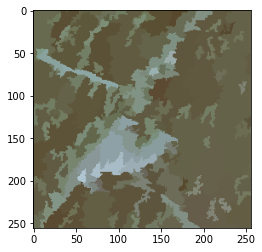

In [9]:


im = cv.imread("fake.png")

srm = SRM(im, 750)
segmented = srm.run()

pyplot.imshow(segmented/256)
pyplot.show()
segmented = Image.fromarray(np.uint8(segmented)).convert('RGB')
im = Image.fromarray(im.astype('uint8'), 'RGB')

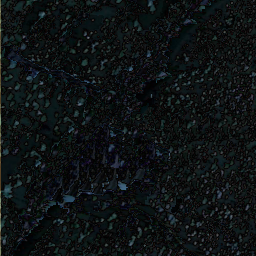

In [10]:


diff = ImageChops.difference(im, segmented)

display(diff)

In [31]:
#quelque transformation clasic : 

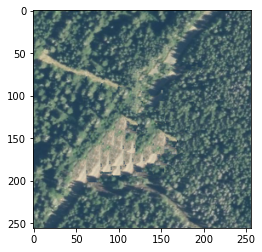

In [33]:
im = imread('fake.png')
plt.imshow(my_dog, cmap='gray');
im_scaled =im
r_scaled = rescale(im[:,:,0], 1)
g_scaled = rescale(im[:,:,1], 1)
b_scaled = rescale(im[:,:,2], 1)
im_scaled = np.stack([r_scaled, g_scaled, b_scaled], axis=2)


In [34]:
im_gray = rescale(rgb2gray(my_dog), 1)

In [35]:
def rgb_convolve2d(image, kernel):
    red = convolve2d(image[:,:,0], kernel, 'valid')
    green = convolve2d(image[:,:,1], kernel, 'valid')
    blue = convolve2d(image[:,:,2], kernel, 'valid')
    return np.stack([red, green, blue], axis=2)

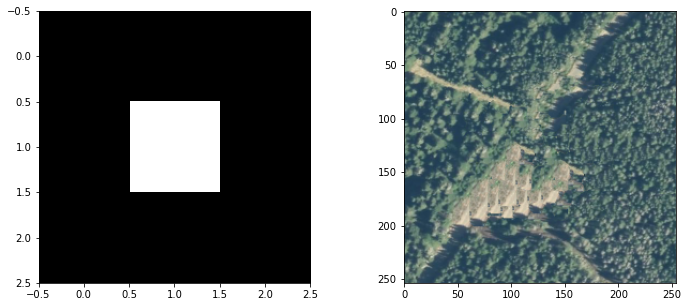

In [36]:
identity = np.array([[0, 0, 0],
                     [0, 1, 0],
                     [0, 0, 0]])
conv_im1 = rgb_convolve2d(im_scaled, identity)
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(identity, cmap='gray')
ax[1].imshow(abs(conv_im1), cmap='gray');

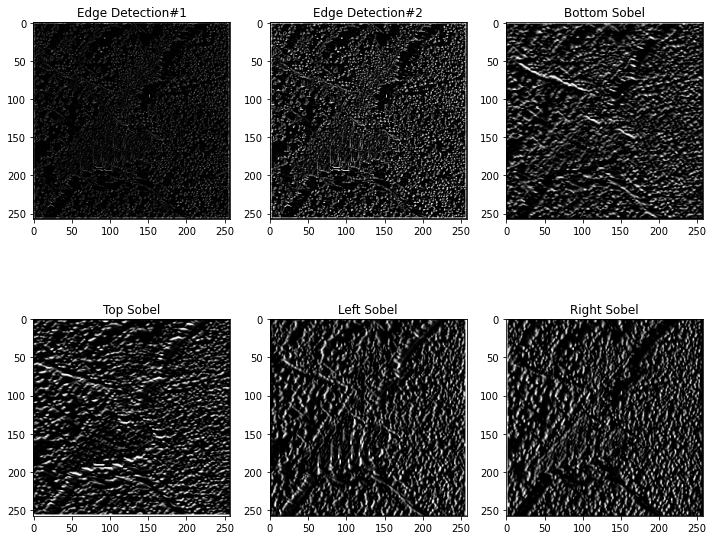

In [37]:
# Edge Detection1
kernel1 = np.array([[0, -1, 0],
                    [-1, 4, -1],
                    [0, -1, 0]])
# Edge Detection2
kernel2 = np.array([[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]])
# Bottom Sobel Filter
kernel3 = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])
# Top Sobel Filter
kernel4 = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]])
# Left Sobel Filter
kernel5 = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])
# Right Sobel Filter
kernel6 = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
kernels = [kernel1, kernel2, kernel3, kernel4, kernel5, kernel6]
kernel_name = ['Edge Detection#1', 'Edge Detection#2', 
               'Bottom Sobel', 'Top Sobel', 
               'Left Sobel', 'Right Sobel']
figure, axis = plt.subplots(2,3, figsize=(12,10))
for kernel, name, ax in zip(kernels, kernel_name, axis.flatten()):
     conv_im1 = convolve2d(im_gray, 
                           kernel[::-1, ::-1]).clip(0,1)
     ax.imshow(abs(conv_im1), cmap='gray')
     ax.set_title(name)

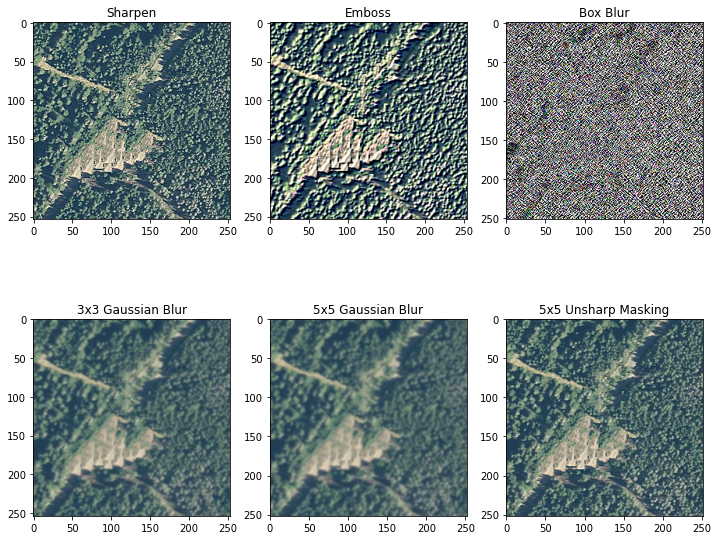

In [38]:
# Sharpen
kernel7 = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

# Emboss
kernel8 =  np.array([[-2, -1, 0],
                     [-1,  1, 1],
                     [ 0,  1, 2]])


# Box Blur
#kernel9 = (1 / 9.0) * np.array([[1, 1, 1],
#                                [1, 1, 1],
#                                [1, 1, 1]])

kernel9 =100 * np.array([[0,0 ,0 ,0 ,0 ],
                                   [0,-1 ,2 ,-1 , 0],
                                   [0, 2, -4,2 ,0 ],
                                   [0, -1, 2,-1 , 0],
                                   [0, 0,0 ,0 ,0 ]])


# Gaussian Blur 3x3
kernel10 = (1 / 16.0) * np.array([[1, 2, 1],
                                  [2, 4, 2],
                                  [1, 2, 1]])


# Gaussian Blur 5x5
kernel11 = (1 / 256.0) * np.array([[1, 4, 6, 4, 1],
                                   [4, 16, 24, 16, 4],
                                   [6, 24, 36, 24, 6],
                                   [4, 16, 24, 16, 4],
                                   [1, 4, 6, 4, 1]])

# Unsharp masking 5x5
kernel12 = -(1 / 256.0) * np.array([[1, 4, 6, 4, 1],
                                   [4, 16, 24, 16, 4],
                                   [6, 24, -476, 24, 6],
                                   [4, 16, 24, 16, 4],
                                   [1, 4, 6, 4, 1]])
kernels = [kernel7, kernel8, kernel9, kernel10, kernel11, kernel12]
kernel_name = ['Sharpen', 'Emboss', 'Box Blur', '3x3 Gaussian Blur', 
               '5x5 Gaussian Blur', '5x5 Unsharp Masking']
figure, axis = plt.subplots(2,3, figsize=(12,10))

for kernel, name, ax in zip(kernels, kernel_name, axis.flatten()):
    conv_im1 = rgb_convolve2d(im_scaled, kernel[::-1, ::-1]).clip(0,1)
    ax.imshow(abs(conv_im1), cmap='gray')
    ax.set_title(name)

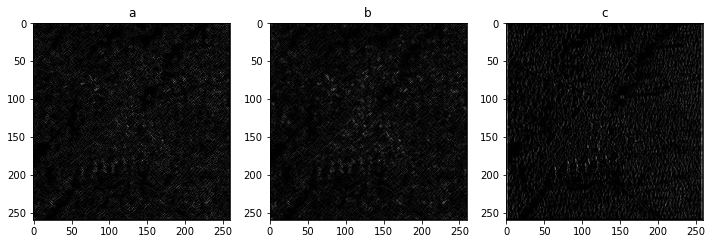

In [39]:
kernela = (1 / 4) * np.array([[0,0 ,0 ,0 ,0 ],
                                   [0,-1 ,2 ,-1 , 0],
                                   [0, 2, -4,2 ,0 ],
                                   [0, -1, 2,-1 , 0],
                                   [0, 0,0 ,0 ,0 ]])

kernelb = (1 / 12) * np.array([[-1,2 ,-2 ,2 ,-1 ],
                                   [2,-6 ,8 ,-6 , 2],
                                   [-2, 8, -12,8 ,-2 ],
                                   [2,-6 ,8 ,-6 , 2],
                                   [-1,2 ,-2 ,2 ,-1 ]])

kernelc = (1 / 2) * np.array([[0, 0,0 ,0 ,0 ],
                                   [0, 0,0 ,0 ,0 ],
                                   [0, 1, -2,1 ,0 ],
                                   [0, 0,0 ,0 ,0 ],
                                   [0, 0,0 ,0 ,0 ]])

kernels = [kernela, kernelb, kernelc]
kernel_name = ['a', 'b', 'c']
figure, axis = plt.subplots(1,3, figsize=(12,10))

#for kernel, name, ax in zip(kernels, kernel_name, axis.flatten()):
#    conv_im1 = rgb_convolve2d(my_dog_scaled, kernel[::-1, ::-1]).clip(0,1)
#    ax.imshow(abs(conv_im1), cmap='gray')
#    ax.set_title(name)
    
for kernel, name, ax in zip(kernels, kernel_name, axis.flatten()):
     conv_im1 = convolve2d(im_gray, 
                           kernel[::-1, ::-1]).clip(0,1)
     ax.imshow(abs(conv_im1*2), cmap='gray')
     ax.set_title(name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


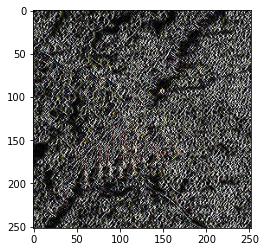

In [42]:
conv_im1 = rgb_convolve2d(im_scaled, kernels[0][::-1, ::-1]).clip(0,1)
conv_im2 = rgb_convolve2d(im_scaled, kernels[1][::-1, ::-1]).clip(0,1)
conv_im3 = rgb_convolve2d(im_scaled, kernels[2][::-1, ::-1]).clip(0,1)
conv_im=conv_im1+conv_im2+conv_im3
plt.imshow(conv_im*10)

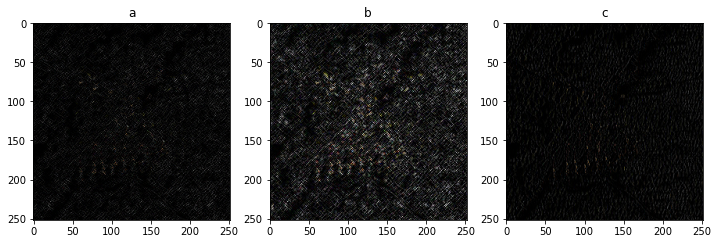

In [43]:
kernela = np.array([[0,0 ,0 ,0 ,0 ],
                                   [0,-1 ,2 ,-1 , 0],
                                   [0, 2, -4,2 ,0 ],
                                   [0, -1, 2,-1 , 0],
                                   [0, 0,0 ,0 ,0 ]])

kernelb =  np.array([[-1,2 ,-2 ,2 ,-1 ],
                                   [2,-6 ,8 ,-6 , 2],
                                   [-2, 8, -12,8 ,-2 ],
                                   [2,-6 ,8 ,-6 , 2],
                                   [-1,2 ,-2 ,2 ,-1 ]])

kernelc =  np.array([[0, 0,0 ,0 ,0 ],
                                   [0, 0,0 ,0 ,0 ],
                                   [0, 1, -2,1 ,0 ],
                                   [0, 0,0 ,0 ,0 ],
                                   [0, 0,0 ,0 ,0 ]])

kernels = [kernela, kernelb, kernelc]
kernel_name = ['a', 'b', 'c']
figure, axis = plt.subplots(1,3, figsize=(12,10))

for kernel, name, ax in zip(kernels, kernel_name, axis.flatten()):
    conv_im1 = rgb_convolve2d(im_scaled, kernel[::-1, ::-1]).clip(0,1)
    ax.imshow(abs(conv_im1), cmap='gray')
    ax.set_title(name)

In [44]:
k=(1/4)*kernels[0]+(1/12)*kernels[1]  +(1/12)*kernels[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


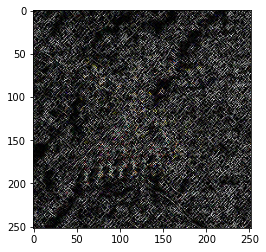

In [46]:
conv_im1 = rgb_convolve2d(im_scaled, k[::-1, ::-1]).clip(0,1)

plt.imshow(conv_im1*10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


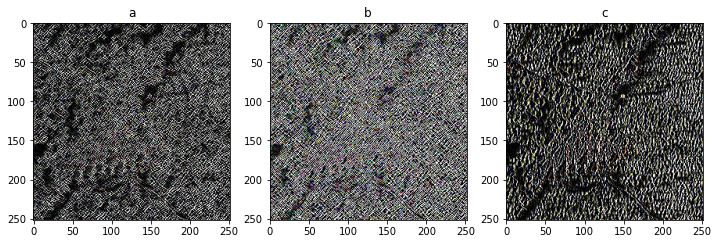

In [51]:
figure, axis = plt.subplots(1,3, figsize=(12,10))
for kernel, name, ax in zip(kernels, kernel_name, axis.flatten()):
    conv_im1 = rgb_convolve2d(im_scaled, kernel[::-1, ::-1]).clip(0,1)
    ax.imshow(abs(conv_im1*10), cmap='gray')
    ax.set_title(name)

In [ ]:
#quelque source peuve etre trouver si apres :
#https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhou_Learning_Rich_Features_CVPR_2018_paper.pdf
#https://arxiv.org/pdf/2106.01532.pdf